In [36]:
#!pip install lightgbm
#!pip install optuna
#!pip memoized_property

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import joblib
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import train_test_split
import dask.dataframe as dd

from income.evaluation import predict_multiple_models
from income.evaluation import evaluate_model

In [4]:
path_models = "s3://data-science-kavak-dev/projects/cerberus/v2/dev/income/models_test/"

In [5]:
train = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")


In [6]:
from income.utils import normalize_core
core = pd.read_csv("data/aprobados.csv", index_col=0)

core = normalize_core(core)
core.shape

(13943, 7)

In [7]:
models = ["%_validado","preds_declarado","preds_sin_declarado" ]

test_df = predict_multiple_models(test_df, models, path_models)


*** Reading %_validado
** Creating columns %_validado
*** Reading preds_declarado
** Creating columns preds_declarado
*** Reading preds_sin_declarado
** Creating columns preds_sin_declarado


In [8]:
test_df["validated_final_model"] = test_df["net_income_verified"]*test_df['%_validado']
test_df["validated_final_model"] =  test_df["validated_final_model"].astype(int)

In [9]:
merge_df = pd.merge(core,test_df,how="inner",left_index=True,right_index=True)

test_df=merge_df.copy()

In [10]:
test_df.shape

(3697, 62)

### Creo flags por cada uno

In [37]:
test_df["real"] = test_df["ingreso_neto_comprobado"]
test_df["ing_declarado"] = test_df["net_income_verified"]


test_df["pred_promedio"] = test_df[["ing_declarado","validated_final_model","preds_declarado","preds_sin_declarado"]].mean(axis=1)
test_df["min_pred"] = test_df[["ing_declarado","validated_final_model","preds_declarado","preds_sin_declarado"]].min(axis=1)


ingresos_pred = ["ingreso_neto_comprobado","validated_final_model","preds_declarado","preds_sin_declarado","min_pred","pred_promedio"]
for pred in ingresos_pred:
    test_df[f"%_diferencia_{pred}"] = ((test_df["net_income_verified"] - test_df[pred])/test_df[pred])
    test_df[f"flag_{pred}"]= np.where((test_df[f"%_diferencia_{pred}"]>=0.5), 1,0)
    cantidad = len(test_df[test_df[f"%_diferencia_{pred}"] > 0.5])
    test_df[f"residuos_{pred}"] = test_df["ingreso_neto_comprobado"] - test_df[pred]
    total= len(test_df)
    porcentaje = cantidad/total
    
    print(f"El porcentaje de clientes con mas de 50% de diferencia cómo flag con {pred} es de {porcentaje*100:.2f}% serian {cantidad} clientes sobre {total}. En un Core de 18mil clientes será de {int(porcentaje*18000)}")

El porcentaje de clientes con mas de 50% de diferencia cómo flag con ingreso_neto_comprobado es de 5.17% serian 191 clientes sobre 3697. En un Core de 18mil clientes será de 929
El porcentaje de clientes con mas de 50% de diferencia cómo flag con validated_final_model es de 0.00% serian 0 clientes sobre 3697. En un Core de 18mil clientes será de 0
El porcentaje de clientes con mas de 50% de diferencia cómo flag con preds_declarado es de 0.14% serian 5 clientes sobre 3697. En un Core de 18mil clientes será de 24
El porcentaje de clientes con mas de 50% de diferencia cómo flag con preds_sin_declarado es de 17.04% serian 630 clientes sobre 3697. En un Core de 18mil clientes será de 3067
El porcentaje de clientes con mas de 50% de diferencia cómo flag con min_pred es de 17.04% serian 630 clientes sobre 3697. En un Core de 18mil clientes será de 3067
El porcentaje de clientes con mas de 50% de diferencia cómo flag con pred_promedio es de 0.11% serian 4 clientes sobre 3697. En un Core de 18m

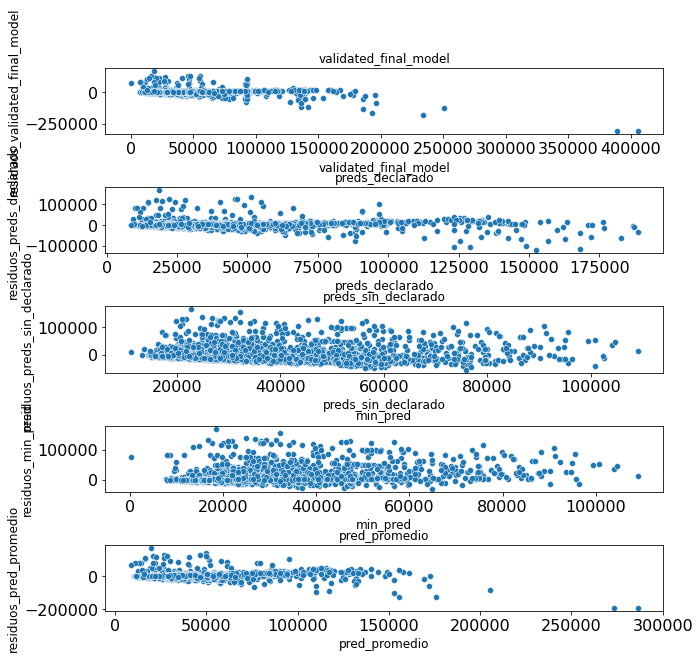

In [38]:
fig, ax = plt.subplots(5,1,figsize=(10,10))
plt.ticklabel_format(style='plain', axis='y')
plt.subplots_adjust(hspace = 0.8)
models = ["validated_final_model","preds_declarado","preds_sin_declarado","min_pred","pred_promedio"]
for i,pred in enumerate(models):
    residuos = f"residuos_{pred}"
    sns.scatterplot(data=test_df, x=pred, y=residuos,ax=ax[i]).set_title(f'{pred}')

In [13]:
ingresos = ["real","ing_declarado","validated_final_model","preds_declarado","preds_sin_declarado","min_pred","pred_promedio"]

for ingreso in ingresos:
    test_df[f"capacidad_{ingreso}"] = (test_df[ingreso] - test_df['descuentos'])/(test_df["Monto_de_la_mensualidad"])
    test_df[f"CAP_{ingreso}"]= np.where((test_df[f"capacidad_{ingreso}"]>=2), 1,0)
    test_df[f"CAP_{ingreso}"]= np.where((test_df[f"CAP_{ingreso}"]==0), "Desaprobado","Aprobado")

In [14]:
from income.utils import create_dinamic

* 1 levanto la nueva data de INTL (la misma sections) fines de marzo
* 2 Armo las preds para validacion de ingreso
* 3 filtros

In [15]:
create_dinamic(test_df)

In [16]:
create_dinamic(test_df)

### MAPE

In [17]:
from income.evaluation import evaluate_model

Modelo ing_declarado  

                      Mape_promedio  Diferencia_promedio  Cantidad_clientes
salarios_min                                                               
1 hasta 2 salarios              NaN                  NaN                NaN
2 hasta 3 salarios         0.220458          2189.612393              280.0
3 hasta 5 salarios         0.108957          1546.213767             1022.0
5 hasta 8 salarios         0.100069          1805.546422             1009.0
8 hasta 12 salarios        0.079523          1253.072865              576.0
12 hasta 16 salarios       0.084445          1624.682285              372.0
+ de 16 salarios           0.131716         -2552.419269              438.0
Modelo validated_final_model  

                      Mape_promedio  Diferencia_promedio  Cantidad_clientes
salarios_min                                                               
1 hasta 2 salarios              NaN                  NaN                NaN
2 hasta 3 salarios         0.213

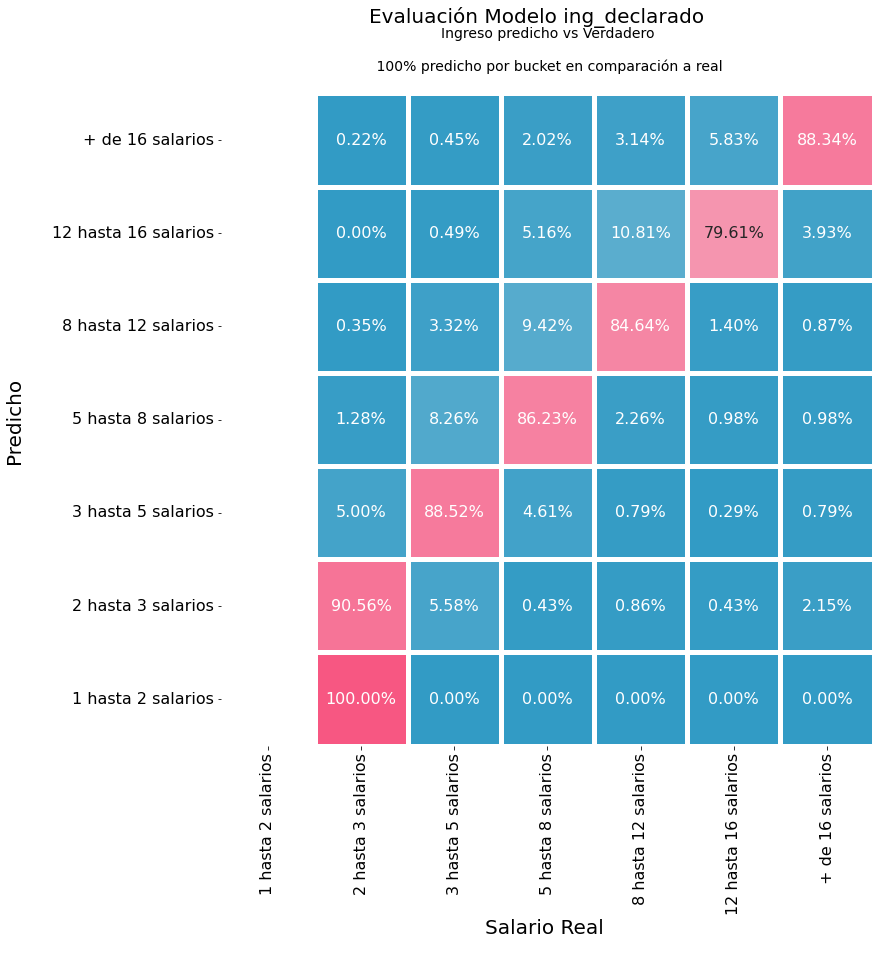

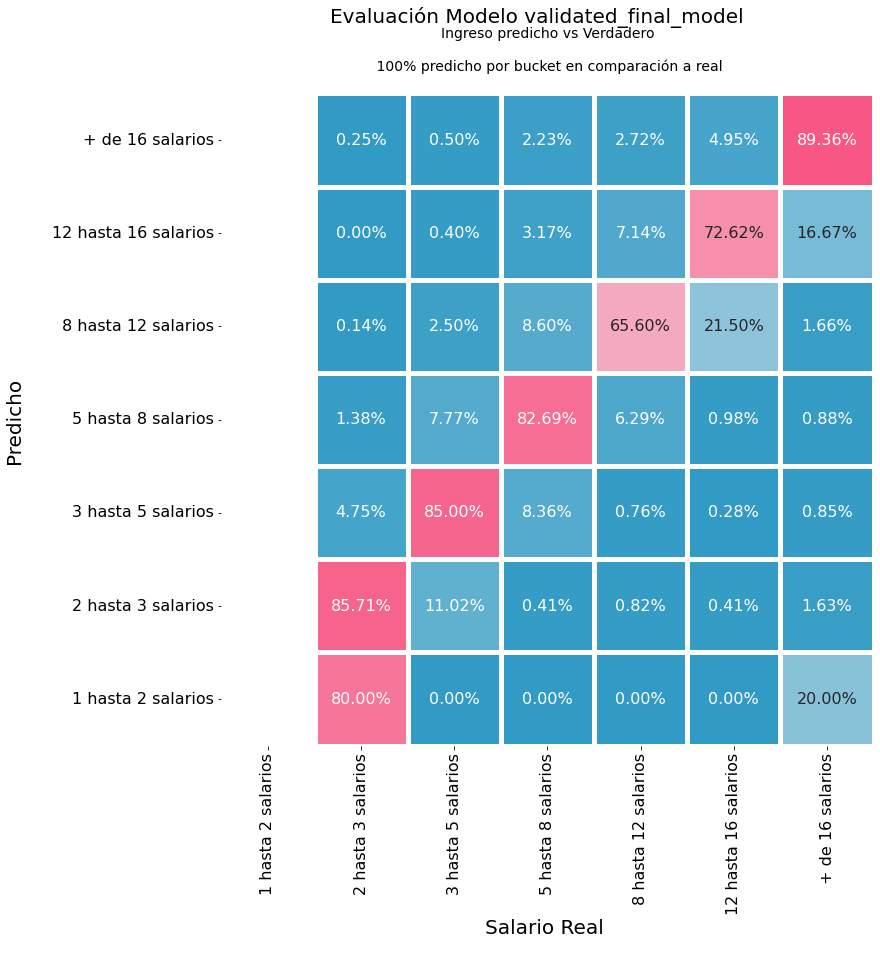

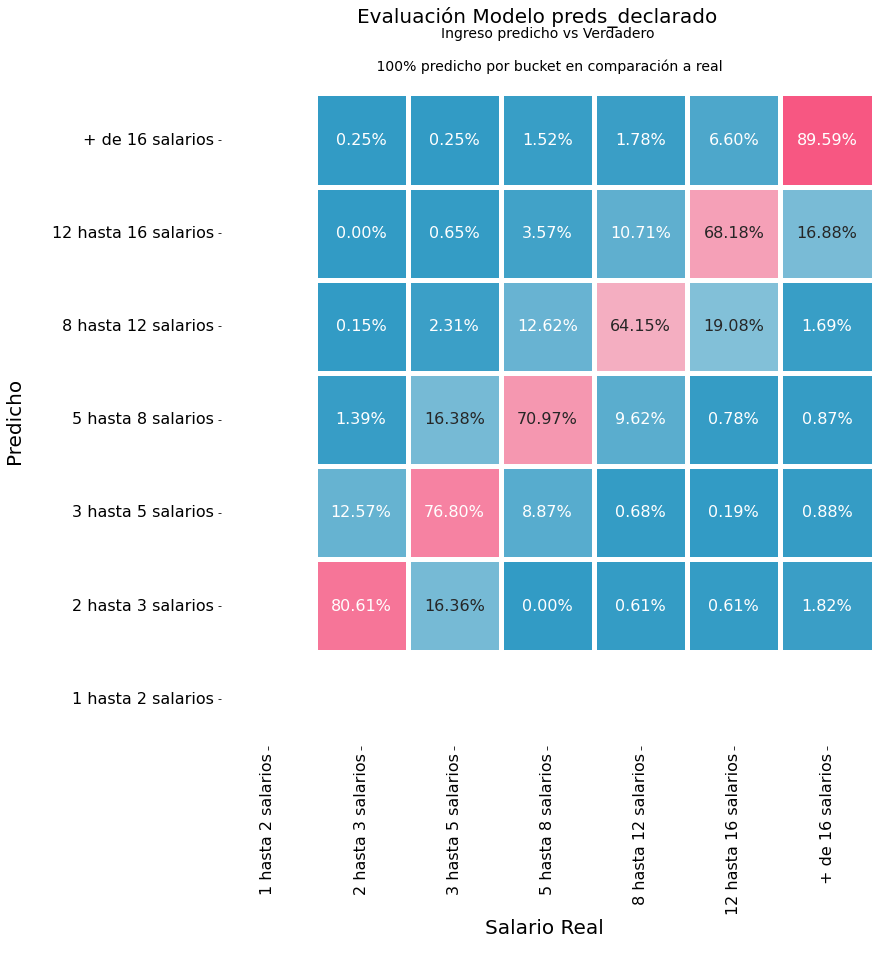

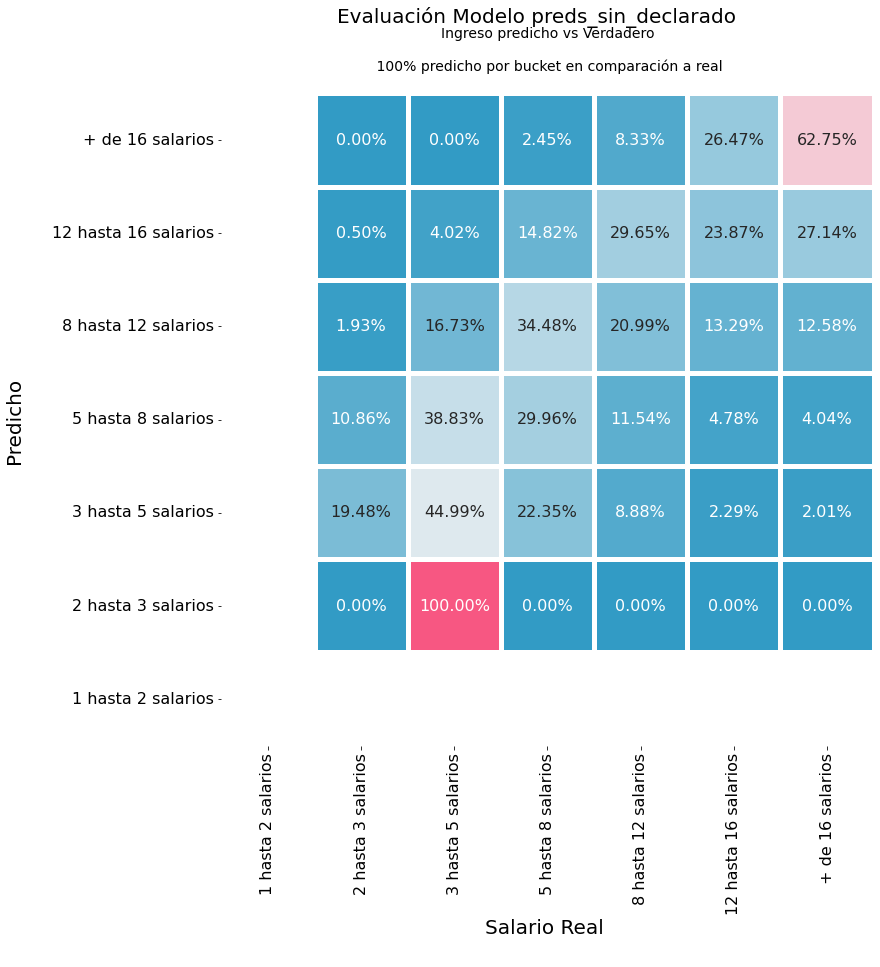

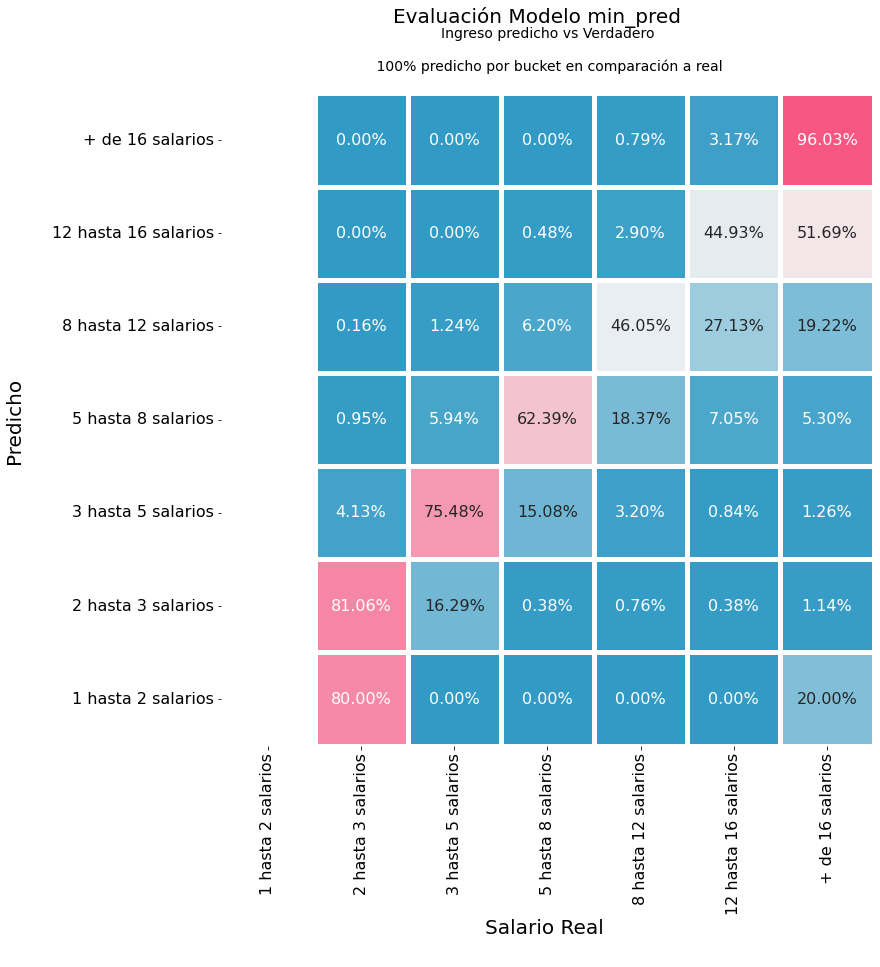

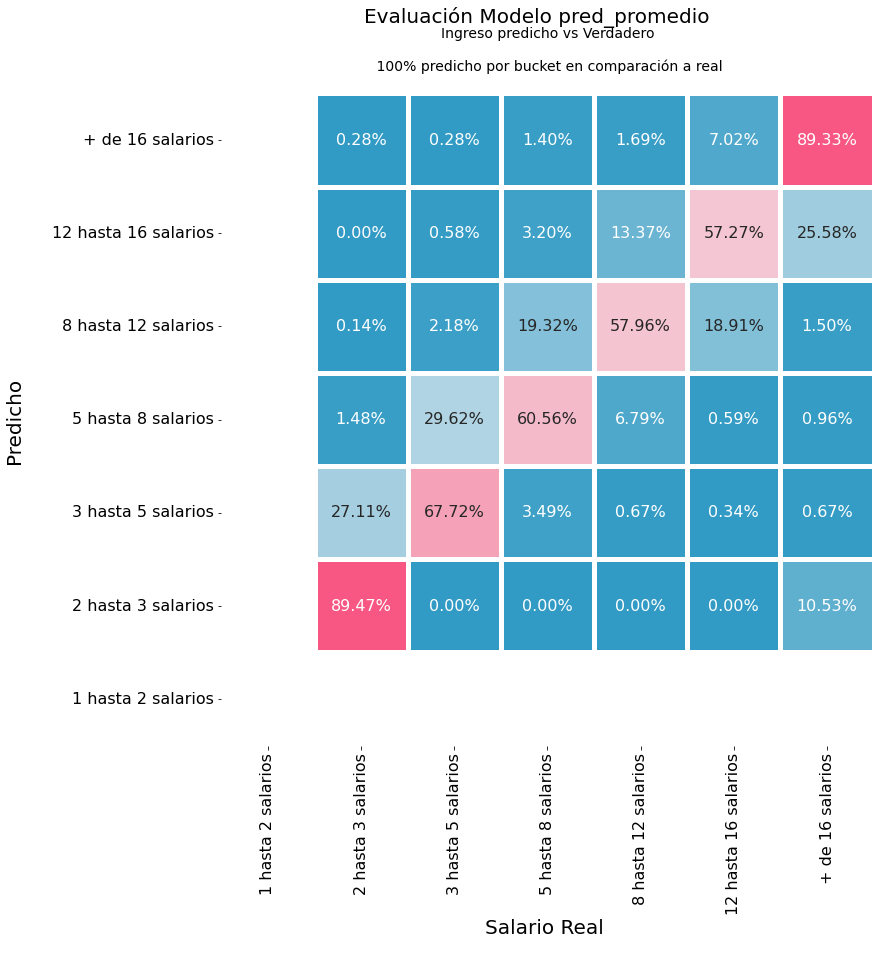

In [21]:
models = ["ing_declarado","validated_final_model","preds_declarado","preds_sin_declarado","min_pred","pred_promedio"]

for modelname in models:
    print("Modelo",modelname," \n")
    evaluate_model(df=test_df, pred=modelname,true="ingreso_neto_comprobado",metric="mape")
    

In [24]:
test_df["validated_final_model"].describe().round(2)

count      3697.00
mean      34614.18
std       28378.49
min          57.00
25%       17318.00
50%       25353.00
75%       41792.00
max      405732.00
Name: validated_final_model, dtype: float64

In [27]:
pd.set_option('display.max_rows', 500)

In [35]:
test_df[test_df["validated_final_model"] > 400000][["ingreso_neto_comprobado","net_income_verified",'%_validado',"validated_final_model","preds_declarado","preds_sin_declarado","min_pred","pred_promedio"]].T.round(2)

,2777
ingreso_neto_comprobado,95791.00
net_income_verified,528714.00
%_validado,0.77
validated_final_model,405732.00
preds_declarado,162851.92
preds_sin_declarado,48403.39
min_pred,48403.39
pred_promedio,286425.33
